In [1]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as utils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import math
from torch.cuda.amp import autocast, GradScaler # For Mixed Precision on A100

# Import your FID calculation function
# Ensure FID.ipynb is in the same directory
from ipynb.fs.full.FID import calculate_fretchet

# Seed for reproducibility
torch.manual_seed(42)

/home/nananda/.conda/envs/ece8550/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/nananda/.conda/envs/ece8550/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- A100 Optimizations ---
# Enable TF32 for faster matrix multiplications on Ampere GPUs
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
# --------------------------

# Hyperparameters
learning_rate = 3e-4
# A100 has massive VRAM, we can use a large batch size for stable gradients
BATCH_SIZE = 512  
image_size = 64
channels_img = 3  
max_epochs = 200  # Increased epochs since A100 trains fast

# DDPM Specific Hyperparameters
NOISE_STEPS = 1000
BETA_START = 0.0001
BETA_END = 0.02

# Load CIFAR-10
dataset = datasets.CIFAR10(root="./dataset/CIFAR10", download=True,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

# Increased num_workers to ensure the GPU isn't waiting for CPU data loading
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, pin_memory=True)

Files already downloaded and verified


/home/nananda/.conda/envs/ece8550/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [3]:
class DiffusionUtils:
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02, img_size=64, device="cuda"):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        self.device = device
        
        # Pre-calculate values for forward and backward pass
        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)
        
    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)
    
    def noise_images(self, x, t):
        """Add noise to images at timestep t"""
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        e = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * e, e

    def sample_timesteps(self, n):
        """Sample random timesteps for training"""
        return torch.randint(low=1, high=self.noise_steps, size=(n,))

In [4]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = (math.log(10000) / (half_dim - 1))
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()

    def forward(self, x, t):
        # First convolution
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend time embedding to spatial dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)

class SimpleUNet(nn.Module):
    """
    A simplified U-Net for CIFAR-10 64x64
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 3 
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) for i in range(len(down_channels)-1)])
        
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) for i in range(len(up_channels)-1)])
        
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # Embed Time
        t = self.time_mlp(timestep)
        x = self.conv0(x)
        residuals = []
        for down in self.downs:
            x = down(x, t)
            residuals.append(x)
        for up in self.ups:
            residual = residuals.pop()
            x = torch.cat((x, residual), dim=1)
            x = up(x, t)
        return self.output(x)

In [5]:
# Initialize Model
model = SimpleUNet().to(device)

# A100 Optimization: Use channels_last memory format for faster CNN operations
model = model.to(memory_format=torch.channels_last)

diffusion = DiffusionUtils(noise_steps=NOISE_STEPS, beta_start=BETA_START, beta_end=BETA_END, img_size=image_size, device=device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
mse = nn.MSELoss()

# A100 Optimization: Gradient Scaler for Automatic Mixed Precision (AMP)
scaler = GradScaler()

# Logging
LossList = []
FID_list = []
best_fid = float('inf')
best_fake_images = None

In [6]:
def sample_images(model, diffusion, n):
    """
    Sample n images from the model. 
    Uses AMP for speed on A100.
    """
    model.eval()
    with torch.no_grad():
        # Start from pure noise
        x = torch.randn((n, 3, diffusion.img_size, diffusion.img_size)).to(device)
        
        # Loop backwards from T to 0
        for i in reversed(range(1, diffusion.noise_steps)):
            t = (torch.ones(n) * i).long().to(device)
            
            # Predict noise using Mixed Precision
            with autocast():
                predicted_noise = model(x, t)
            
            alpha = diffusion.alpha[t][:, None, None, None]
            alpha_hat = diffusion.alpha_hat[t][:, None, None, None]
            beta = diffusion.beta[t][:, None, None, None]
            
            if i > 1:
                noise = torch.randn_like(x)
            else:
                noise = torch.zeros_like(x)
            
            x = (1 / torch.sqrt(alpha)) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
            
    model.train()
    # Clamp to [-1, 1] and convert to [0, 255] uint8
    x = (x.clamp(-1, 1) + 1) / 2 
    x = (x * 255).type(torch.uint8)
    return x

In [7]:
from torch.nn.utils import clip_grad_norm_

print("Starting Training on A100 (with Gradient Clipping)...")

# Reset best_fid so we capture new bests
best_fid = float('inf')

for epoch in range(max_epochs):
    epoch_loss = 0
    model.train()
    
    for batch_idx, (real_images, _) in enumerate(dataloader):
        # Move data to channels_last format for A100 speed
        real_images = real_images.to(device, memory_format=torch.channels_last)
        
        t = diffusion.sample_timesteps(real_images.shape[0]).to(device)
        x_t, noise = diffusion.noise_images(real_images, t)
        
        optimizer.zero_grad()
        
        # --- Mixed Precision Training ---
        with autocast():
            predicted_noise = model(x_t, t)
            loss = mse(noise, predicted_noise)
        
        # Scale Gradients
        scaler.scale(loss).backward()
        
        # --- CRITICAL FIX: Gradient Clipping ---
        # 1. Unscale the gradients so we can measure them correctly
        scaler.unscale_(optimizer)
        # 2. Clip gradients to a max norm of 1.0 to prevent explosion/NaNs
        clip_grad_norm_(model.parameters(), 1.0)
        
        # Step optimizer
        scaler.step(optimizer)
        scaler.update()
        
        epoch_loss += loss.item()
    
    # Check for NaN loss immediately
    if math.isnan(epoch_loss):
        print(f"!! NaN Loss detected at Epoch {epoch}. Stopping training to prevent crash.")
        break

    avg_loss = epoch_loss / len(dataloader)
    LossList.append(avg_loss)
    
    # --- Evaluation Section ---
    if (epoch + 1) % 5 == 0:
        # 1. Generate Fake Images
        fake_images_uint8 = sample_images(model, diffusion, n=BATCH_SIZE)
        
        # 2. Prepare Real Images
        real_images_uint8 = (real_images * 0.5 + 0.5).clamp(0, 1) * 255
        real_images_uint8 = real_images_uint8.type(torch.uint8)
        
        # 3. Calculate FID
        # Convert to float for Inception model
        real_fid_input = real_images_uint8.float() / 255.0
        fake_fid_input = fake_images_uint8.float() / 255.0
        
        try:
            fid_score = calculate_fretchet(real_fid_input, fake_fid_input)
        except Exception as e:
            print(f"FID calculation error: {e}")
            fid_score = 999.0
            
        FID_list.append(fid_score)
        
        if fid_score < best_fid:
            best_fid = fid_score
            best_fake_images = fake_images_uint8.clone()
            
        print(f"Epoch [{epoch+1}/{max_epochs}] | Loss: {avg_loss:.4f} | FID Score: {fid_score:.3f}")
    else:
        print(f"Epoch [{epoch+1}/{max_epochs}] | Loss: {avg_loss:.4f}")

Starting Training on A100 (with Gradient Clipping)...
Epoch [1/200] | Loss: 0.2584
Epoch [2/200] | Loss: 0.0570
Epoch [3/200] | Loss: 0.0312
Epoch [4/200] | Loss: 0.0244
Epoch [5/200] | Loss: 0.0215 | FID Score: 246.047
Epoch [6/200] | Loss: 0.0199
Epoch [7/200] | Loss: 0.0184
Epoch [8/200] | Loss: 0.0169
Epoch [9/200] | Loss: 0.0162
Epoch [10/200] | Loss: 0.0156 | FID Score: 140.419
Epoch [11/200] | Loss: 0.0154
Epoch [12/200] | Loss: 0.0148
Epoch [13/200] | Loss: 0.0143
Epoch [14/200] | Loss: 0.0151
Epoch [15/200] | Loss: 0.0139 | FID Score: 140.892
Epoch [16/200] | Loss: 0.0139
Epoch [17/200] | Loss: 0.0135
Epoch [18/200] | Loss: 0.0134
Epoch [19/200] | Loss: 0.0136
Epoch [20/200] | Loss: 0.0133 | FID Score: 225.960
Epoch [21/200] | Loss: 0.0131
Epoch [22/200] | Loss: 0.0130
Epoch [23/200] | Loss: 0.0129
Epoch [24/200] | Loss: 0.0129
Epoch [25/200] | Loss: 0.0127 | FID Score: 129.866
Epoch [26/200] | Loss: 0.0128
Epoch [27/200] | Loss: 0.0124
Epoch [28/200] | Loss: 0.0124
Epoch [29/

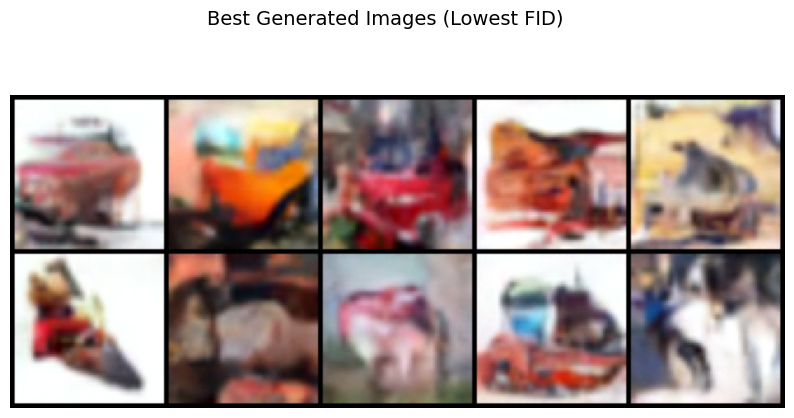

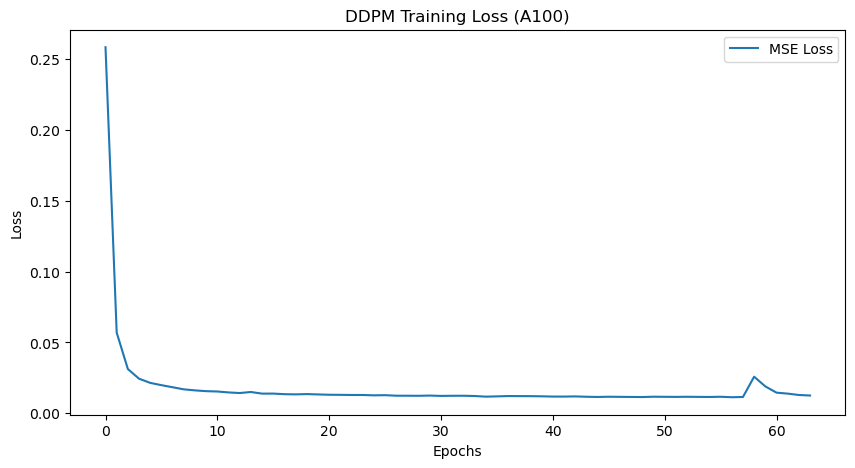

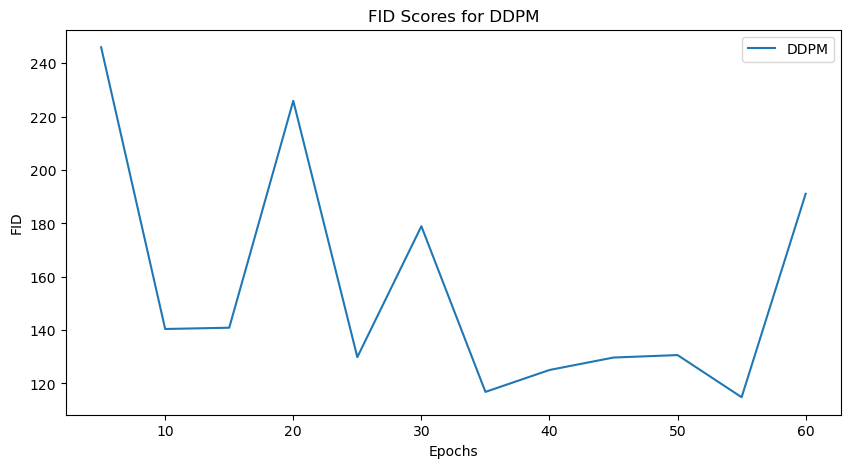

In [8]:
# Display the best generated images
if best_fake_images is not None:
    plt.figure(figsize=(10, 5))
    plt.suptitle("Best Generated Images (Lowest FID)", fontsize=14)
    # Convert back to float [0,1] for matplotlib
    show_imgs = best_fake_images[:10].float() / 255.0
    grid = utils.make_grid(show_imgs, nrow=5, normalize=False)
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.axis("off")
    plt.show()       

# Plot Loss
plt.figure(figsize=(10,5))
plt.title("DDPM Training Loss (A100)")
plt.plot(LossList, label="MSE Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig('DDPM_LOSS.pdf', format='pdf', dpi=100, bbox_inches='tight')
plt.show()

# Plot FID
plt.figure(figsize=(10,5))
plt.title("FID Scores for DDPM")
x_epochs = range(5, len(FID_list)*5 + 1, 5)
plt.plot(x_epochs, FID_list, label="DDPM")
plt.xlabel("Epochs")
plt.ylabel("FID")
plt.legend()
plt.savefig('DDPM_FID.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Save stats
np.save('DDPM_FID', FID_list)
np.save('DDPM_LOSS', LossList)